# Chapter 2 Discussion: Statistical Paradoxes


Observation bias and sub-group differences can produce statistical paradoxes in any data science application. In Chapter 2, we saw the most common paradoxes encountered in causal inference. Let's discuss two examples in class.

### Discussion 1, Clinical Trials

Imagine we are trying to work out whether a certain drug is an effective treatment for a disease. 

To decide whether it is effective, we compare people who took the treatment by examining how many of each recovered from the disease.
Suppose the results are as follows:

| treatment=0 | treatment=1  |
|-------------|--------------|
|  177/250 (recovered); 73/250 (died)    |   110/250 (recovered); 140/250 (died)    |

**What is the conclusion? Is the drug effective?**

When we just look at the *total* value at the bottom in the table above, we find that of 250 people who took the drug, 110 recovered (44%), whereas out of the 250 people who did not take the drug 177 recovered (71%). From these results it looks like there is a clear advantage to not taking the drug!

Now, suppose we dividided the test population into different groups by age to five groups. What do we observe?

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import utils as u
from IPython.core.display import HTML

HTML(u.create_table(pd.read_csv("data/Simpson_paradox_binary_example.csv")))

**Is the conclusion the same? why?**

### Discussion 2, Dating

Let’s assume that people have two independent characteristics: beauty and personality.   
If we plot this population as a scatter ploy, the population should look as randomly distributed on the looks-niceness plane. Each person is a point in this plane.

<AxesSubplot:xlabel='beauty', ylabel='personality'>

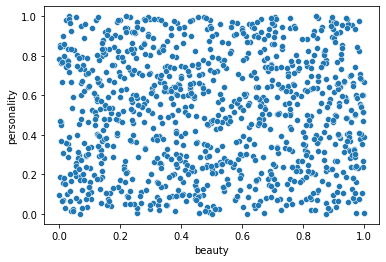

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Generate two independent characteristics (beauty,personality) in people
N_people = 1000
population = pd.DataFrame(data = {'beauty' : np.random.uniform(low = 0, high = 1, size = N_people),
                                  'personality' : np.random.uniform(low = 0, high = 1, size = N_people)})
sns.scatterplot(data=population, x = 'beauty', y = 'personality')

Let's assume that a girl wants to date a guy in the top right corner of the plot, which is a man that is both handsome and nice. 
However, if a guy is a jerk sometimes, she might still date him if he is really good-looking. 
Similarly, if a guy is really nice, she might still date him even if he is not so good-looking. 


Thus, by simplifying (a lot) the dating process, the guys that she is willing to date are probably where:

**Niceness + Handsomeness > a constant value**  (Orange points inthe plot below)

<AxesSubplot:xlabel='beauty', ylabel='personality'>

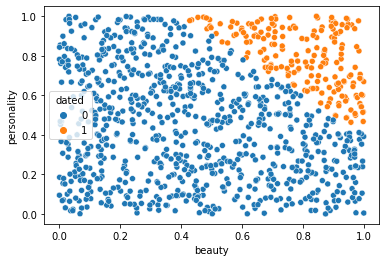

In [2]:
def dating_function(person, threshold = 1.4):
    if person['beauty'] + person['personality'] >= threshold:
        val = 1
    else:
        val = 0
    return val

population['dated'] = population.apply(dating_function, axis=1)

sns.scatterplot(data=population, x = 'beauty', y = 'personality', hue = 'dated')

By restricting herself to this set of guys, she sees a negative correlation between looks and niceness, **despite** these two variables being independent in the population!

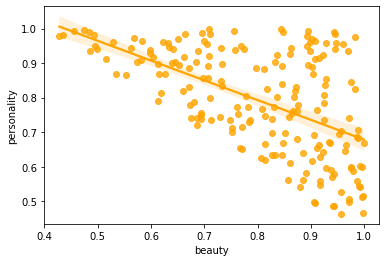

In [3]:
sns.regplot(x="beauty", y="personality", data=population[population['dated'] == 1], color="orange");

If we try to find a conclusion out of this study we could say that generally good-looking people are generally jerks and funny people and ugly. 

**Does it meake sense?**

Let's try with another "dating function"...

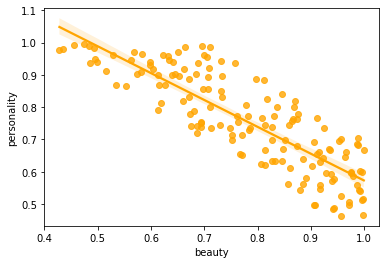

In [4]:
def dating_function_2(person, threshold_1 = 1.4, threshold_2 = 1.7):
    if person['beauty'] + person['personality'] >= threshold_1 and person['beauty'] + person['personality'] <= threshold_2:
        val = 1
    else:
        val = 0
    return val

population['dated'] = population.apply(dating_function_2, axis=1)

sns.regplot(x="beauty", y="personality", data=population[population['dated'] == 1], color="orange");

**It seems like the more we condition (i.e. observe) to a particular group, the more the independent variables become correlated!**

What's worse, is that it is possible that if we take into account another variable the correlation might be reversed again. This is why random controlled trials are so important for separating correlation and causation.

Here is a blog on [Are handsome men really jerks?](http://corysimon.github.io/articles/berksons-paradox-are-handsome-men-really-jerks/)

</br></br>
## Discussion 3, Statistical Paradox

An effective way to visualize a statistical paradox is considering a continuos distribution example. A simple example would be look at the Covariance between two variables, $x$ and $y$, which is one sign for a collection of subgroups, but a different sign for the whole population.

In [6]:
def generate_gaussian_simpsons_paradox(n_subgroups=3, n_samples=1000):

    overall_cov = 3*np.array([[1,0.9], [0.9,1]])

    means = np.random.multivariate_normal(mean=[0,0], cov=overall_cov, size=n_subgroups)
    
    weights = np.random.uniform(size=n_subgroups)
    weights /= np.sum(weights)
    covs = [np.random.uniform(0.2,0.8) for _ in range(n_subgroups)]
    covs = [np.array([[1,-c], [-c,1]]) for c in covs]


    samples = []

    for sg, (mean, cov, w) in enumerate(zip(means, covs, weights)):
        n = int(round(n_samples * w))
        sample = np.random.multivariate_normal(mean=mean, cov=cov, size=n)
        sample = pd.DataFrame(sample, columns=["x", "y"])
        sample["z"] = sg
        samples.append(sample)
        
    df = pd.concat(samples)
    
    return df



In [7]:
np.random.seed(1)

df = generate_gaussian_simpsons_paradox()
print("Total Covariance: {:.3f}".format(df[["x", "y"]].cov().iloc[0,1]))
for z in df.z.unique():
    print("Subgroup {} covariance: {:.3f}".format(z,df[df.z==z][["x", "y"]].cov().iloc[0,1]))

Total Covariance: 2.237
Subgroup 0 covariance: -0.688
Subgroup 1 covariance: -0.252
Subgroup 2 covariance: -0.604


This is clearer if we plot what's going on.

For the overall population, there is a positive correlation between $x$ and $y$:

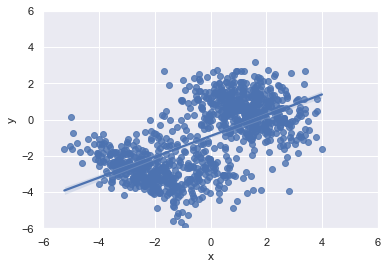

In [8]:
sns.regplot(data=df, x="x", y="y");
plt.xlim(-6,6);
plt.ylim(-6,6);

However for each subpopulation, the correlation is negative!

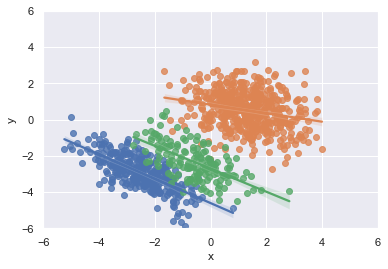

In [9]:
fig, ax = plt.subplots()

plt.xlim(-6,6);
plt.ylim(-6,6);

for z in df.z.unique():
    sns.regplot(data=df[df.z==z], x="x", y="y", ax=ax)

**Do we need to look at the data as a whole or as a group?**